In [20]:
import warnings
warnings.filterwarnings("ignore")

import os
import dateparser
import pandas as pd
import json
import nltk
import numpy as np
import string
import re
import csv
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from functions import *
import dateparser
from fuzzysearch import find_near_matches
from ccfMitchell import ccf

In [21]:
siteCounts = json.load(open('siteCounts.json'))
dateCounts = defaultdict(int)
paperCounts = defaultdict(lambda: defaultdict(int))
for paper_name, paperEntry in siteCounts.items():
    for entry in paperEntry:
        sp = entry['date_range'] if type(entry['date_range'])!=list else entry['date_range'][0]
        month, day, year = sp.split('/')[:]
        diffFormatDate = '{}-{}-{}'.format(year, month, day)
        dateCounts[diffFormatDate]+=entry['site_count']
        paperCounts[paper_name][diffFormatDate]+=entry['site_count']

#### Function

Adding plot function here in case you want that

In [179]:
def plot_2timeseries_no_axis(l1, l2, title='', xlabel='', xticks_rotate=False, skip=0, plt_args={},
                     xticksFontSize=16, yticksFontSize=16, xLabelFontSize=16, ylabelFontSize=16, 
                     sameY=False, yline=None, save_path=None, year_range=[2017,2020]):
    xticksFontSize=plt_args.get('xticksFontSize',28)
    yticksFontSize=plt_args.get('yticksFontSize',28)
    xlabelFontSize=plt_args.get('xlabelFontSize',35)
    ylabelFontSize=plt_args.get('ylabelFontSize',28)
    titleFontSize=plt_args.get('titleFontSize',28)
    legendFontSize=plt_args.get('legendFontSize',45)
    figSize=plt_args.get('figSize',(15,8))
    
    plt.figure(figsize=figSize)

    # l1
    fig, ax1 = plt.subplots(figsize=figSize)
    plot_color = l1.get('color', 'r')
    if l1.get('type', None) == 'bar':
        ax1.bar([i[0] for i in l1['count_list']], [i[1] for i in l1['count_list']],
                color=plot_color, label=l1['label'])
    else:
        lns1 = ax1.plot([i[0] for i in l1['count_list']], [i[1] for i in l1['count_list']],
                 linestyle='-', marker='x', color=plot_color, label=l1['label'], markersize=10, linewidth=5)
    ax1.set_xlabel(xlabel, fontsize=xlabelFontSize)
    ax1.set_ylabel(l1.get('ylabel', ''), color=plot_color, fontsize=ylabelFontSize)
    ax1.tick_params(axis='y', labelcolor=plot_color, labelsize=yticksFontSize)
    ax1.tick_params(axis='x', labelrotation=90 if xticks_rotate else None, labelsize=xticksFontSize)
#     ax1.legend(fontsize=legendFontSize, loc='upper left')
    x1minVal, x1maxVal = calculate_ylim([i[1] for i in l1['count_list']])
    ylim_min, ylim_max = l1.get('ylim_min', x1minVal), l1.get('ylim_max', x1maxVal)
    ax1.set_ylim(ylim_min, ylim_max)

    # l2
    ax2 = ax1.twinx()
    plot_color = l2.get('color', 'b')
    if l2.get('type', None) == 'bar':
        ax2.bar([i[0] for i in l2['count_list']], [i[1] for i in l2['count_list']],
                color=plot_color, label=l1['label'])
    else:
        lns2 = ax2.plot([i[0] for i in l2['count_list']], [i[1] for i in l2['count_list']],
                 linestyle='-', marker='o', color=plot_color, label=l2['label'], markersize=10, linewidth=5)
    ax2.set_xlabel(xlabel, fontsize=xlabelFontSize)
    ax2.set_ylabel(l2.get('ylabel', ''), color=plot_color, fontsize=ylabelFontSize)
    ax2.tick_params(axis='y', labelcolor=plot_color, labelsize=yticksFontSize)
    ax2.tick_params(axis='x', labelrotation=90 if xticks_rotate else None, labelsize=xticksFontSize)
#     ax2.legend(fontsize=legendFontSize, loc='upper left')
    x2minVal, x2maxVal = calculate_ylim([i[1] for i in l2['count_list']])
    ylim_min, ylim_max = l1.get('ylim_min', x2minVal), l1.get('ylim_max', x2maxVal)
    ax2.set_ylim(ylim_min, ylim_max)
    
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    plt.legend(lns, labs, loc='upper left',fontsize=legendFontSize)
    
    if sameY:
        minVal, maxVal = min(x1minVal, x2minVal), max(x1maxVal,x2maxVal)
        ax1.set_ylim(minVal, maxVal)
        ax2.set_yticks([])
#         ax2.set_ylim(minVal, maxVal)
            

    plt.xticks([i[0] for i in l2['count_list']])

    fig.suptitle(title, fontsize=titleFontSize, y=title.count('\n') * .05 + 1.02)
    #     if xticks_rotate: fig.xticks(rotation='vertical')
    if skip:
        temp = ax1.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::skip]))
        for label in temp:
            label.set_visible(False)
        
#     ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    if yline:
        plt.axhline(yline)
        plt.text(len(l1['count_list'])-0.75, yline+(yline/16), '{}'.format(yline) )
        
    xt = []
    for i in range(year_range[0],year_range[1]+1): xt.extend([str(i)]*12)
    ax1.set_xticklabels(xt)
    
    fig.tight_layout()
    if save_path: plt.savefig(save_path, dpi=128)
    plt.show()

In [176]:
def plot_2timeseries(l1, l2, title='', xlabel='', xticks_rotate=False, skip=0, plt_args={},
                     xticksFontSize=16, yticksFontSize=16, xLabelFontSize=16, ylabelFontSize=16, 
                     sameY=False, yline=None, save_path=None, year_range=[2017,2020]):
    xticksFontSize=plt_args.get('xticksFontSize',28)
    yticksFontSize=plt_args.get('yticksFontSize',28)
    xlabelFontSize=plt_args.get('xlabelFontSize',28)
    ylabelFontSize=plt_args.get('ylabelFontSize',28)
    titleFontSize=plt_args.get('titleFontSize',28)
    legendFontSize=plt_args.get('legendFontSize',28)
    figSize=plt_args.get('figSize',(15,7))
    
    plt.figure(figsize=figSize)

    # l1
    fig, ax1 = plt.subplots(figsize=figSize)
    plot_color = l1.get('color', 'r')
    if l1.get('type', None) == 'bar':
        ax1.bar([i[0] for i in l1['count_list']], [i[1] for i in l1['count_list']],
                color=plot_color, label=l1['label'])
    else:
        ax1.plot([i[0] for i in l1['count_list']], [i[1] for i in l1['count_list']],
                 linestyle='-', marker='x', color=plot_color, label=l1['label'], markersize=10)
    ax1.set_xlabel(xlabel, fontsize=xlabelFontSize)
    ax1.set_ylabel(l1.get('ylabel', ''), color=plot_color, fontsize=ylabelFontSize)
    ax1.tick_params(axis='y', labelcolor=plot_color, labelsize=yticksFontSize)
    ax1.tick_params(axis='x', labelrotation=90 if xticks_rotate else None, labelsize=xticksFontSize)
    ax1.legend(fontsize=legendFontSize, loc='upper left')
    x1minVal, x1maxVal = calculate_ylim([i[1] for i in l1['count_list']])
    ylim_min, ylim_max = l1.get('ylim_min', x1minVal), l1.get('ylim_max', x1maxVal)
    ax1.set_ylim(ylim_min, ylim_max)

    # l2
    ax2 = ax1.twinx()
    plot_color = l2.get('color', 'b')
    if l2.get('type', None) == 'bar':
        ax2.bar([i[0] for i in l2['count_list']], [i[1] for i in l2['count_list']],
                color=plot_color, label=l1['label'])
    else:
        ax2.plot([i[0] for i in l2['count_list']], [i[1] for i in l2['count_list']],
                 linestyle='-', marker='o', color=plot_color, label=l2['label'])
    ax2.set_xlabel(xlabel, fontsize=xlabelFontSize)
    ax2.set_ylabel(l2.get('ylabel', ''), color=plot_color, fontsize=ylabelFontSize)
    ax2.tick_params(axis='y', labelcolor=plot_color, labelsize=yticksFontSize)
    ax2.tick_params(axis='x', labelrotation=90 if xticks_rotate else None, labelsize=xticksFontSize)
    ax2.legend(fontsize=legendFontSize, loc='upper right')
    x2minVal, x2maxVal = calculate_ylim([i[1] for i in l2['count_list']])
    ylim_min, ylim_max = l1.get('ylim_min', x2minVal), l1.get('ylim_max', x2maxVal)
    ax2.set_ylim(ylim_min, ylim_max)
    
    if sameY:
        minVal, maxVal = min(x1minVal, x2minVal), max(x1maxVal,x2maxVal)
        ax1.set_ylim(minVal, maxVal)
        ax2.set_yticks([])
#         ax2.set_ylim(minVal, maxVal)
            

    plt.xticks([i[0] for i in l2['count_list']])
    

    fig.suptitle(title, fontsize=titleFontSize, y=title.count('\n') * .05 + 1.02)
    #     if xticks_rotate: fig.xticks(rotation='vertical')
    if skip:
        temp = ax1.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::skip]))
        for label in temp:
            label.set_visible(False)
    
    xt = []
    for i in range(year_range[0],year_range[1]+1): xt.extend([str(i)]*12)
    ax1.set_xticklabels(xt)
    
    if yline:
        plt.axhline(yline)
        plt.text(len(l1['count_list'])-0.75, yline+(yline/16), '{}'.format(yline) )
    fig.tight_layout()
    if save_path: plt.savefig(save_path, dpi=128)
    plt.show()

## Load data

In [23]:
ignoreDates = {2020:[9,10,11,12]}
division = 'sylhet'

News Media

In [24]:
article_filepath = 'timeseries_data/yearPublished_day/yearPublished_day.json'
articleDates = json.load(open(article_filepath))

article_filepath = article_filepath = 'timeseries_data/yearPublished_day/yearPublished_day_{}.json'.format(division.lower())
articleDatesDivision = json.load(open(article_filepath))

Twitter

In [25]:
twitter_filepath = 'timeseries_data/twitter/TwitterAll.json'
twitterData = json.load(open(twitter_filepath))

twitter_filepath = 'timeseries_data/twitter/Twitter{}.json'.format(division.capitalize())
twitterDataDivision = json.load(open(twitter_filepath))

Sentinel1

In [26]:
aggSentinel = get_Sentinel1_data_monthly('all', ignoreDates=ignoreDates)
aggSentinelDivision = get_Sentinel1_data_monthly(division, ignoreDates=ignoreDates)

## News-EM-DAT

<Figure size 1080x504 with 0 Axes>

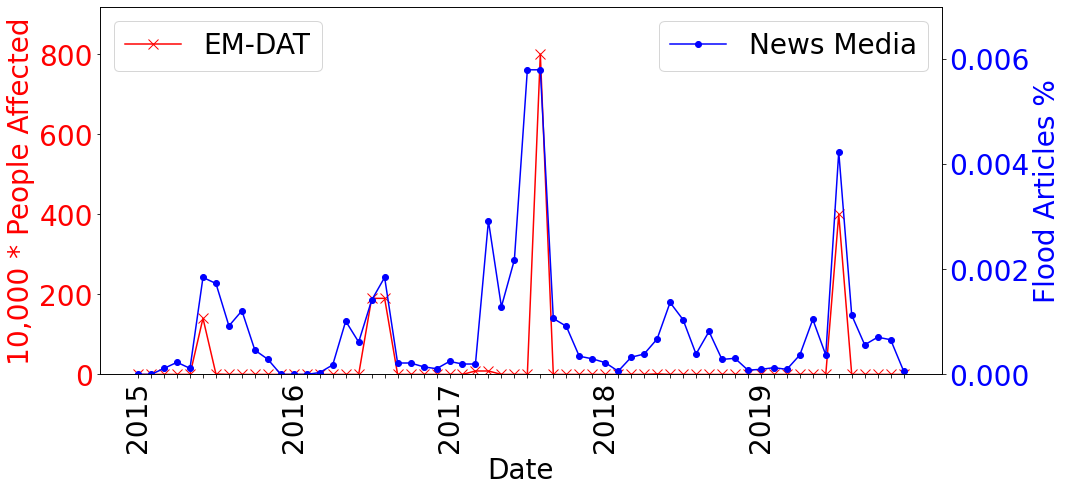

Spearmen Corr, pval: 0.4721, p-val=0.0001400375824572237, n=60
Pearson Corr, pval: 0.6807, p-val=2.187180143257582e-09, n=60


((0.4721, 0.0001400375824572237, 60), (0.6807, 2.187180143257582e-09, 60))

In [177]:
emdat_df = pd.read_csv('other_data/emdat_flood.csv').drop('Unnamed: 0', axis=1).fillna(0)
year_month = []
for row in emdat_df.iterrows():
    if int(row[1]['Start Month']):
        year_month.append(('{}-{}'.format(int(row[1]['Start Year']), int(row[1]['Start Month'])), 
                           row[1]['Total Affected']/10000))
    if int(row[1]['End Month']):
        year_month.append(('{}-{}'.format(int(row[1]['End Year']), int(row[1]['End Month'])), 
                        row[1]['Total Affected']/10000))
# year_month = complete_day(year_month, year_range=[2017,2020], aggType='month', ignoreDates={2020:[8,9]})
aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2015,2019], 
                      aggType='month', normDict=dateCounts, normAgg='year')
aggDay, year_month = match_years_months(aggDay, year_month, [2015,2019])
plot_2timeseries(
            {'count_list': year_month, 'label':'EM-DAT', 
             'color':'r', 'ylabel':'10,000 * People Affected'},
            {'count_list': aggDay, 'label':'News Media', 
             'color': 'b', 'ylabel': 'Flood Articles %'},
            '', 'Date', True, skip=12, save_path='images/paper/news_emdat.pdf', year_range=[2015,2019])
ccf(year_month, aggDay, tupList=True, plot=True,
    title='10,000* People Affected (EMDAT data) and \n Normalized Flood articles (yearly)', lag_max=40)

## News-Twitter

### All

<Figure size 1080x504 with 0 Axes>

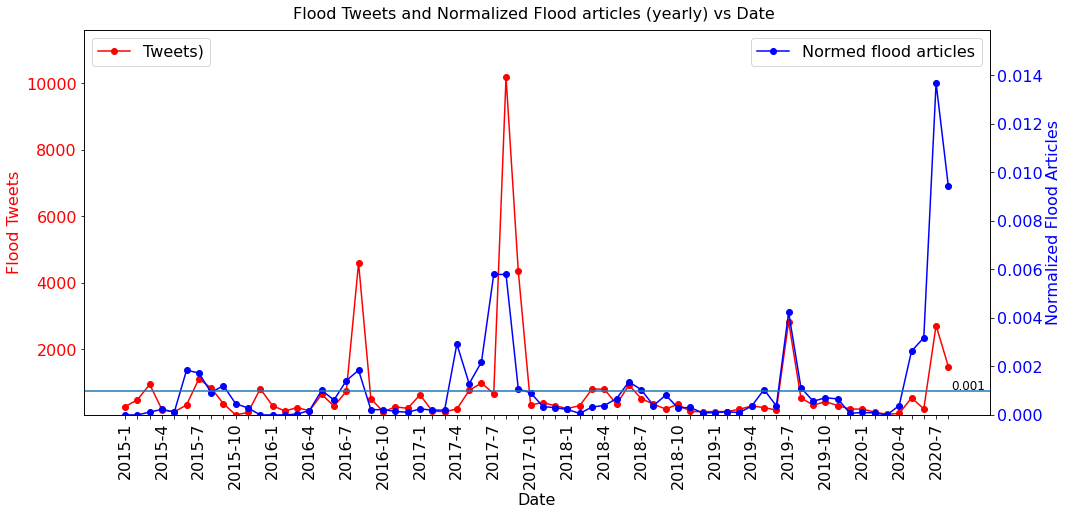

Spearmen Corr, pval: 0.5712, p-val=3.640994995919603e-07, n=68
Pearson Corr, pval: 0.4667, p-val=6.021506871714784e-05, n=68


((0.5712, 3.640994995919603e-07, 68), (0.4667, 6.021506871714784e-05, 68))

In [12]:
twitterDataList = complete_day([(k,v) for k,v in twitterData.items()], aggType='month', 
                               year_range=[2015,2020], ignoreDates=ignoreDates)

aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2015,2020], 
                      aggType='month', normDict=dateCounts, normAgg='year', ignoreDates=ignoreDates)

plot_2timeseries(
            {'count_list': twitterDataList, 'label':'Tweets)', 
             'color':'r', 'ylabel':'Flood Tweets'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': 'Normalized Flood Articles'},
            'Flood Tweets and Normalized Flood articles (yearly) vs Date', 'Date', True, skip=3, yline=0.001)
ccf(aggDay, twitterDataList, tupList=True, plot=True,
    title='Twitter Data and \n Normalized Flood articles (yearly)', lag_max=50)

### Sylhet

<Figure size 1080x504 with 0 Axes>

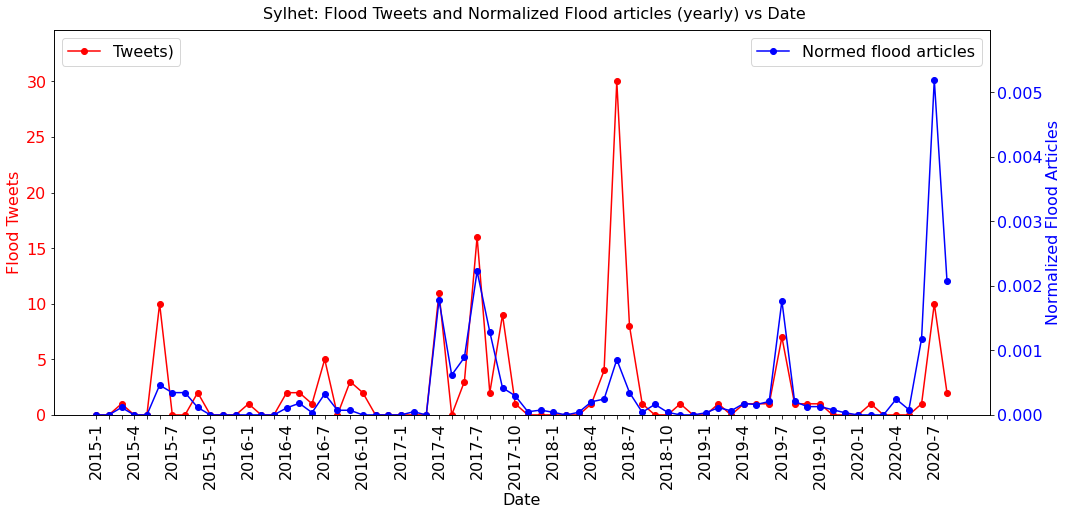

Spearmen Corr, pval: 0.6563, p-val=1.2357582849346993e-09, n=68
Pearson Corr, pval: 0.5005, p-val=1.3843954233701668e-05, n=68


((0.6563, 1.2357582849346993e-09, 68), (0.5005, 1.3843954233701668e-05, 68))

In [13]:
twitterDataList = complete_day([(k,v) for k,v in twitterDataDivision.items()], aggType='month', 
                               year_range=[2015,2020], ignoreDates=ignoreDates)

aggDay = complete_day([(k,v) for k,v in articleDatesDivision.items()], year_range=[2015,2020], 
                      aggType='month', normDict=dateCounts, normAgg='year', ignoreDates=ignoreDates)

plot_2timeseries(
            {'count_list': twitterDataList, 'label':'Tweets)', 
             'color':'r', 'ylabel':'Flood Tweets'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': 'Normalized Flood Articles'},
            '{}: Flood Tweets and Normalized Flood articles (yearly) vs Date'.format(division.capitalize()), 
    'Date', True, skip=3)
ccf(aggDay, twitterDataList, tupList=True, plot=True,
    title='Twitter Data and \n Normalized Flood articles (yearly)', lag_max=40)

## News-Sentinel1

### All

<Figure size 1080x504 with 0 Axes>

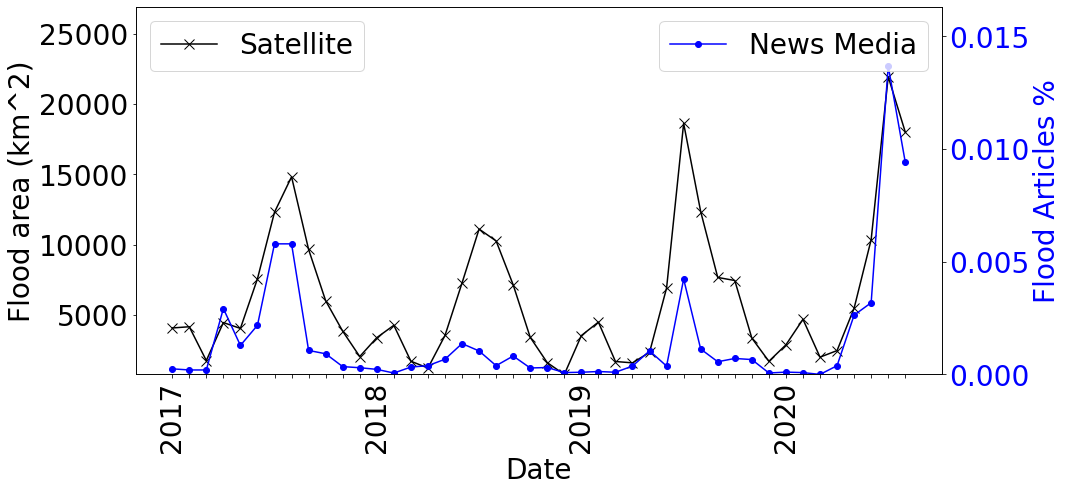

Spearmen Corr, pval: 0.696, p-val=1.5643603817293738e-07, n=44
Pearson Corr, pval: 0.8215, p-val=8.389908518171541e-12, n=44


((0.696, 1.5643603817293738e-07, 44), (0.8215, 8.389908518171541e-12, 44))

In [181]:
aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,2020], 
                      aggType='month', normDict=dateCounts, normAgg='year', ignoreDates=ignoreDates)
plot_2timeseries(
            {'count_list': aggSentinel, 'label':'Satellite', 
             'color':'black', 'ylabel':'Flood area (km^2)'},
            {'count_list': aggDay, 'label':'News Media', 
             'color': 'b', 'ylabel': 'Flood Articles %'},
            '', 'Date', True, skip=12, save_path='images/paper/news_sentinel1.pdf', year_range=[2017,2020] )
ccf(aggSentinel, aggDay, tupList=True, plot=True,
    title='Sentinel1 (max over month) and Normed Flood articles (yearly)'.format(division.capitalize()), lag_max=40)


<Figure size 1080x576 with 0 Axes>

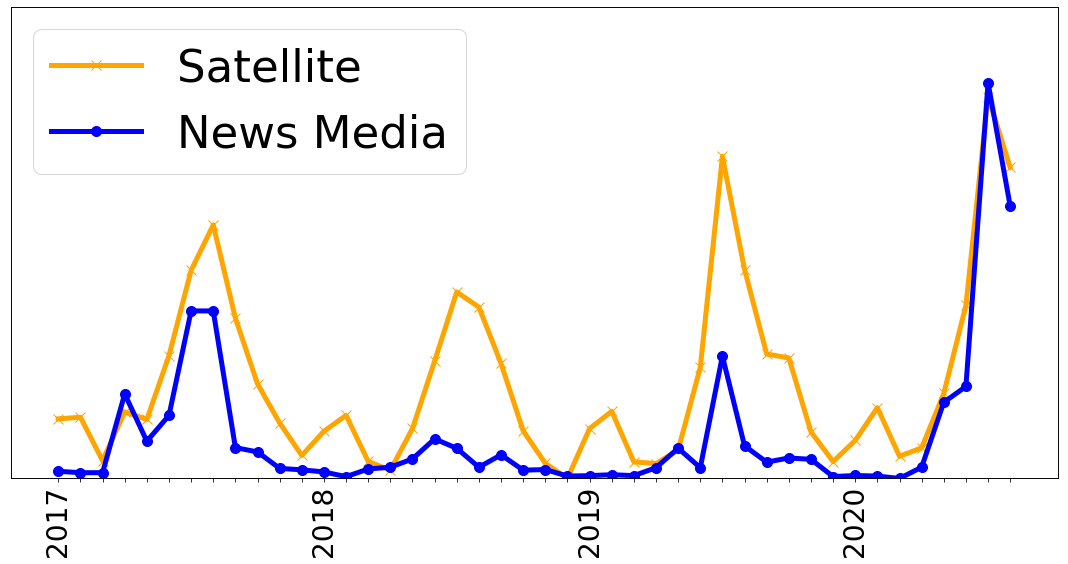

Spearmen Corr, pval: 0.696, p-val=1.5643603817293738e-07, n=44
Pearson Corr, pval: 0.8215, p-val=8.389908518171541e-12, n=44


((0.696, 1.5643603817293738e-07, 44), (0.8215, 8.389908518171541e-12, 44))

In [180]:
aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,2020], 
                      aggType='month', normDict=dateCounts, normAgg='year', ignoreDates=ignoreDates)
plot_2timeseries_no_axis(
            {'count_list': aggSentinel, 'label':'Satellite', 
             'color':'orange', 'ylabel':'1,000 * Total \nArea Flooded (km^2)'},
            {'count_list': aggDay, 'label':'News Media', 
             'color': 'b', 'ylabel': 'News Articles %'},
            '', '', True, skip=12, save_path='images/paper/news_sentinel_no_axis.pdf', year_range=[2017,2020] )
ccf(aggSentinel, aggDay, tupList=True, plot=True,
    title='Sentinel1 (max over month) and Normed Flood articles (yearly)'.format(division.capitalize()), lag_max=40)


### Sylhet

<Figure size 1080x504 with 0 Axes>

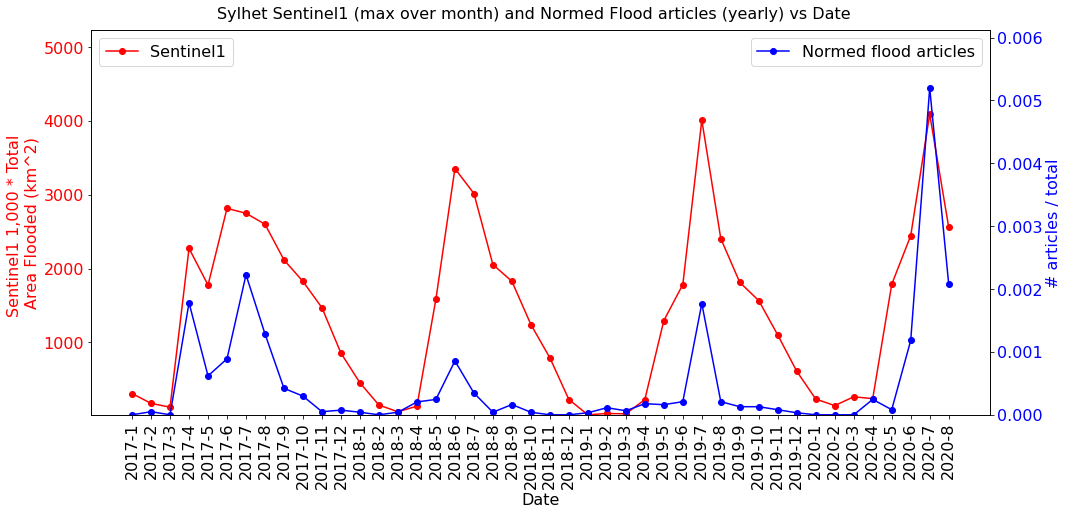

Spearmen Corr, pval: 0.7646, p-val=1.5324548415898584e-09, n=44
Pearson Corr, pval: 0.6913, p-val=2.0474125734287735e-07, n=44


((0.7646, 1.5324548415898584e-09, 44), (0.6913, 2.0474125734287735e-07, 44))

In [16]:
aggDay = complete_day([(k,v) for k,v in articleDatesDivision.items()], year_range=[2017,2020], 
                      aggType='month', normDict=dateCounts, normAgg='year', ignoreDates=ignoreDates)
plot_2timeseries(
            {'count_list': aggSentinelDivision, 'label':'Sentinel1', 
             'color':'r', 'ylabel':'Sentinel1 1,000 * Total \nArea Flooded (km^2)'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': '# articles / total'},
            '{} Sentinel1 (max over month) and Normed Flood articles (yearly) vs Date'.format(division.capitalize()), 
    'Date', True)
ccf(aggSentinelDivision, aggDay, tupList=True, plot=True,
    title='{} Sentinel1 (max over month) and Normed Flood articles (yearly)'.format(division.capitalize()), lag_max=40)
